In [17]:
#New version of the layer number optimisier script incase i fuck it up
import json
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
from scipy.optimize import minimize

# Packages for quantum stuff
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeBrisbane, FakeSherbrooke, FakeTorino # For simulation with realistic noise

objective_func_vals = []
numOptimisations = 0 # Tracks iterations within a single minimize call
RESULTS_FOLDER = "optimalDepthExperimentResults"
os.makedirs(RESULTS_FOLDER, exist_ok=True) # Ensure results folder exists

In [4]:
def generate_results_filename(problem_type, num_qubits, simulator_name):
    # Sanitize simulator_name for filename (e.g., remove specific instance details if any)
    sim_name_clean = simulator_name.split('(')[0].replace('-', '_').lower()
    return f"depth_results_{str(problem_type).replace(' ', '_')}_{num_qubits}q_{sim_name_clean}.json"

def load_results_data(filename, current_problem_type, current_num_qubits, current_simulator_name):
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            try:
                data = json.load(f)
                # Validate if the loaded data matches current experiment parameters
                if (data.get("problem_type") == current_problem_type and
                    data.get("num_qubits") == current_num_qubits and
                    data.get("simulator_name") == current_simulator_name):
                    print(f"Successfully loaded existing results from {filename}")
                    return data
                else:
                    print(f"Warning: File {filename} exists but metadata does not match current experiment. Starting fresh for this combination.")
            except json.JSONDecodeError:
                print(f"Warning: File {filename} is corrupted or not valid JSON. Starting fresh.")
    # If file doesn't exist, or loading failed, or metadata mismatch, create a new structure
    print(f"No previous exisiting results found. Creating new data structure for {filename}.")
    return {
        "problem_type": current_problem_type,
        "num_qubits": current_num_qubits,
        "simulator_name": current_simulator_name,
        "results_by_depth": {} # Stores lists of costs: { "p_depth_str": [cost1, cost2, ...] }
    }

def save_results_data(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"Results updated and saved to {filename}")

def load_qubo_and_build_hamiltonian(file_path):
    """
    Loads QUBO terms, weights, and constant from a JSON file.
    Determines the number of qubits from the terms and constructs
    the Hamiltonian as a Qiskit SparsePauliOp.
    """
    with open(file_path, "r") as f:
        all_qubo_data = json.load(f)

    if isinstance(all_qubo_data, list):
        # If it's a list, take the first element
        qubo_data = all_qubo_data[0]
    else:
        # If it's already a dictionary, just use it directly
        qubo_data = all_qubo_data

    terms = qubo_data["terms"]
    weights = qubo_data["weights"]
    constant = qubo_data.get("constant", 0.0)
    problemType = qubo_data.get("problem_type")

    pauli_list = []
    num_qubits = 0

    if terms:
        # Flatten the list of lists and filter out empty sublists or non-integer elements
        all_indices = []
        for term_group in terms:
            if isinstance(term_group, list): # Ensure it's a list
                for idx in term_group:
                    if isinstance(idx, int): # Ensure index is an integer
                        all_indices.append(idx)

        if all_indices: # If there are any valid integer indices
            num_qubits = max(all_indices) + 1
        else: # No indices and no weights (only constant)
            num_qubits = 0
    else: # No terms at all
        num_qubits = 0
        if weights: # Weights present but no terms - problematic
            print("Warning: Weights are present, but 'terms' list is empty or missing. Cannot form Pauli operators.")

    for term_indices, weight in zip(terms, weights):
        if not term_indices or not all(isinstance(idx, int) for idx in term_indices):
            # Skip if term_indices is empty or contains non-integers
            continue

        paulis_arr = ["I"] * num_qubits
        if len(term_indices) == 1: # Linear term
            paulis_arr[term_indices[0]] = "Z"
        elif len(term_indices) == 2: # Quadratic term
            paulis_arr[term_indices[0]] = "Z"
            paulis_arr[term_indices[1]] = "Z"
        else:
            # This case should ideally not be hit if terms are only single or pairs.
            print(f"Warning: Skipping term {term_indices} with unsupported number of variables for Pauli Z construction.")
            continue
        pauli_list.append(("".join(paulis_arr)[::-1], weight))

    if not pauli_list and num_qubits > 0: # No valid Pauli terms were created, but num_qubits > 0
        cost_hamiltonian = SparsePauliOp(["I"] * num_qubits, [0]) # Zero operator on n_qubits
    elif not pauli_list and num_qubits == 0:
        cost_hamiltonian = SparsePauliOp("I", [0]) # Placeholder for 1 qubit if everything is empty
    else:
        cost_hamiltonian = SparsePauliOp.from_list(pauli_list)

    return cost_hamiltonian, constant, num_qubits, problemType

def cost_func_estimator(params, ansatz, estimator, cost_hamiltonian_logical, constant_offset): # removed default for backend_total_qubits
    global numOptimisations
    prepared_observable = cost_hamiltonian_logical.apply_layout(ansatz.layout)
    pub = (ansatz, prepared_observable, [params])
    
    job = estimator.run(pubs=[pub])
    results = job.result()[0]
    cost = results.data.evs[0]

    cost_float = float(np.real(cost)) + constant_offset
    objective_func_vals.append(cost_float)
    
    numOptimisations = numOptimisations + 1
    #print(f"Params: {params}, Cost: {cost_float}, Optimisation Round: {numOptimisations}") 
    print(f"Optimisation Iteration: {numOptimisations}", end="\r")  
    
    return cost_float

In [5]:
# ///////////    Variables    //////////
#cost_hamiltonian, constant_offset, num_qubits, problem_type = load_qubo_and_build_hamiltonian("QUBO_batches/batch_QUBO_data_TSP_9q_.json")
qubo_file_paths = [
    "QUBO_batches/batch_QUBO_data_TSP_9q_.json",
    "QUBO_batches/batch_QUBO_data_Knapsack_9q_.json"
]
depth_list = [1, 2, 3] # Depths to test
chosenBackend = FakeTorino() #optionsa are FakeBrisbane(), FakeSherbrooke(), FakeTorino(), 'noiseless'

# ///////////    New Control Variables    //////////
MIN_REPS = 30        # The minimum number of runs for each depth
MAX_REPS = 300        # A safety limit to prevent excessively long runs
SEM_THRESHOLD = 0.005

In [ ]:
# ///////////    Iteration and Optimization Loop    //////////
for file_path in qubo_file_paths:
    print(f"\n{'='*60}\n===== PROCESSING FILE: {file_path} =====\n{'='*60}")

    cost_hamiltonian, constant_offset, num_qubits, problem_type = load_qubo_and_build_hamiltonian(file_path)

    print(f"Number of qubits: {num_qubits}")
    print("Problem type:", problem_type)

    if chosenBackend == 'noiseless':
        backend_simulator = AerSimulator()
    else:
        backend_simulator = AerSimulator.from_backend(chosenBackend)
    estimator = Estimator(mode=backend_simulator)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend_simulator)

    simulator_name_for_file = backend_simulator.name.split('(')[1].lower().replace(')', '') if "fake" in backend_simulator.name.lower() else "aer_simulator_ideal"
    base_filename = generate_results_filename(problem_type, num_qubits, simulator_name_for_file)
    results_filename_with_path = os.path.join(RESULTS_FOLDER, base_filename)
    ALL_RESULTS_DATA = load_results_data(results_filename_with_path, problem_type, num_qubits, simulator_name_for_file)

    for p_depth in depth_list:
        print(f"\n--- Processing Depth (p): {p_depth} for {problem_type} ({num_qubits}q) on {simulator_name_for_file} ---")
        
        depth_key = str(p_depth) # JSON keys must be strings

        # Initialize or retrieve existing results for this depth
        if depth_key not in ALL_RESULTS_DATA["results_by_depth"]:
            ALL_RESULTS_DATA["results_by_depth"][depth_key] = []
        costs_at_this_depth = ALL_RESULTS_DATA["results_by_depth"][depth_key]
        
        # Prepare the circuit for this depth (done once)
        circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p_depth)
        candidate_circuit = pm.run(circuit)
        print(f"  Circuit for depth {p_depth} created. Num params: {2*p_depth}. Transpiled depth: {candidate_circuit.depth()}")
        
        previous_sem = float('inf')  # Initialize with a large value

        # Loop until convergence criteria are met or max repetitions are reached
        while len(costs_at_this_depth) < MAX_REPS:
            num_runs_so_far = len(costs_at_this_depth)

            # Check for convergence if we have completed the minimum number of repetitions
            if num_runs_so_far >= MIN_REPS and num_runs_so_far % 5 == 0:
                # Calculate Standard Error of the Mean (SEM) using sample standard deviation (ddof=1)
                current_sem = np.std(costs_at_this_depth, ddof=1) / np.sqrt(num_runs_so_far)
                sem_change = abs(previous_sem - current_sem)
                
                print(f"  Run {num_runs_so_far}: Current SEM = {current_sem:.6f}, Change from previous = {sem_change:.6f}")

                if sem_change < SEM_THRESHOLD:
                    print(f"  Convergence met: SEM change ({sem_change:.6f}) is below threshold ({SEM_THRESHOLD}).")
                    break # Exit the while loop for this depth
                previous_sem = current_sem

            # --- Perform one optimization run ---
            print(f"  Running Repetition {num_runs_so_far + 1} for depth {p_depth}...")
            
            objective_func_vals = [] # Reset for each minimize call
            numOptimisations = 0   # Reset for each minimize call

            num_params = 2 * p_depth
            initial_params = np.random.rand(num_params) * np.pi
            
            result = minimize(
                cost_func_estimator,
                initial_params,
                args=(candidate_circuit, estimator, cost_hamiltonian, constant_offset),
                method="COBYLA",
                tol=1e-3,
                options={"maxiter": 1000} 
            )
            final_cost = float(f"{result.fun:.4f}")
            print(f"\n  Completed Rep {num_runs_so_far + 1}: Optimal Cost = {final_cost}") # Added newline for clarity

            # Add the new result and save progress immediately
            costs_at_this_depth.append(final_cost)
            ALL_RESULTS_DATA["results_by_depth"][depth_key] = costs_at_this_depth
            save_results_data(ALL_RESULTS_DATA, results_filename_with_path)

        else: # This 'else' clause executes if the while loop finishes without a 'break'
            print(f"  Reached maximum repetitions ({MAX_REPS}) for depth {p_depth}. Stopping.")
    print(f"\n--- All depths processed for {file_path} ---")

print("\n--- All depths processed ---")


===== PROCESSING FILE: QUBO_batches/batch_QUBO_data_TSP_9q_.json =====
Number of qubits: 9
Problem type: tsp
No previous exisiting results found. Creating new data structure for depthVsCostResults/depth_results_tsp_9q_fake_torino.json.

--- Processing Depth (p): 1 for tsp (9q) on fake_torino ---
  Circuit for depth 1 created. Num params: 2. Transpiled depth: 238
  Running Repetition 1 for depth 1...
Optimisation Iteration: 24
  Completed Rep 1: Optimal Cost = 98.2773
Results updated and saved to depthVsCostResults/depth_results_tsp_9q_fake_torino.json
  Running Repetition 2 for depth 1...
Optimisation Iteration: 22
  Completed Rep 2: Optimal Cost = 118.0801
Results updated and saved to depthVsCostResults/depth_results_tsp_9q_fake_torino.json
  Running Repetition 3 for depth 1...
Optimisation Iteration: 25
  Completed Rep 3: Optimal Cost = 100.7617
Results updated and saved to depthVsCostResults/depth_results_tsp_9q_fake_torino.json
  Running Repetition 4 for depth 1...
Optimisation It

Number of points in distribution per depth, 1: 230, 2: 300, 3: 300


/var/folders/ph/hp043kk921q2v4grp3l2v6nw0000gq/T/ipykernel_49462/3264908626.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(plotData,


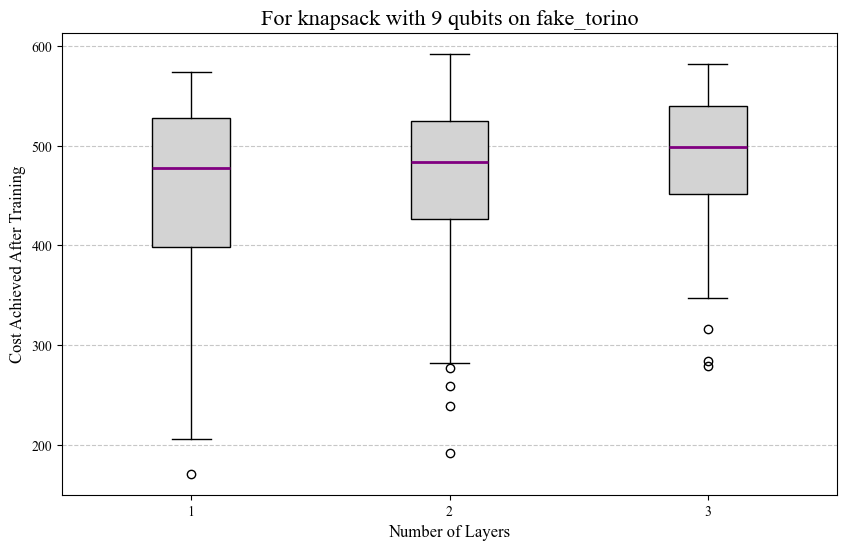

In [21]:
#fileToPlot = 'optimalDepthExperimentResults/depth_results_tsp_9q_fake_torino.json' 
fileToPlot = 'optimalDepthExperimentResults/depth_results_knapsack_9q_fake_torino.json' 



with open(fileToPlot, 'r') as f:
    data = json.load(f)
    plotProblemType = data.get("problem_type")
    plotQubitNum = data.get("num_qubits")
    plotBackendName = data.get("simulator_name")
    plotDataRaw = data.get("results_by_depth", {})

sortedDepths = sorted(plotDataRaw.keys(), key=int)
plotData = [plotDataRaw[depth] for depth in sortedDepths]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Generate the box plots
box = ax.boxplot(plotData,
                    labels=sortedDepths,
                    patch_artist=True,  # Fill with color
                    medianprops=dict(color='purple', linewidth=2)) # Style the median line
for patch in box['boxes']:
    patch.set_facecolor('lightgrey')

ax.set_title(f'For {plotProblemType} with {plotQubitNum} qubits on {plotBackendName}', fontsize=16)
ax.set_xlabel('Number of Layers', fontsize=12)
ax.set_ylabel('Cost Achieved After Training', fontsize=12)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

print(f"Number of points in distribution per depth, 1: {len(plotData[0])}, 2: {len(plotData[1])}, 3: {len(plotData[2])}")
